In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple, Optional, Union
import scipy.stats as stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

In [3]:
def validate_data(data: pd.DataFrame, required_columns: List[str]) -> bool:
    """
    Validate input data integrity
    """
    if data is None or data.empty:
        return False

    missing_cols = [col for col in required_columns if col not in data.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
        return False

    for column in required_columns:
        if data[f'{column}'].isnull().value_counts()[True] > 0:
            print(f'Error: {column} contains null values')
            return False

    return True

In [5]:
def validate_parameters(params: Dict) -> bool:
    """
    Validate simulation parameters
    """
    required_params = ['T', 'dt', 'sigma', 'A', 'k']
    for param in required_params:
        if param not in params or params[param] <= 0:
            print(f"Invalid parameter: {param}")
            return False

    if params['dt'] >= params['T']:
        print("Time step dt must be smaller than total time T")
        return False

    return True

### Generated data

In [7]:
BASE_CONFIG = {
    'random_seed': 42,
    'significance_level': 0.05,
    'confidence_interval': 0.95,
    'n_simulations': 1000,
    'T': 1.0,
    'dt': 0.005,
    'sigma': 2.0,
    'initial_price': 100.0,
    'A': 140.0,
    'k': 1.5,
    'gamma_values': [0.01, 0.1, 0.5]
}

In [9]:
class MarketMakingSimulatorForGeneratedData:
    """
    Monte Carlo simulator for market making strategies
    """

    def __init__(self, config: Dict):
        self.config = config
        self.T = config['T']
        self.dt = config['dt']
        self.sigma = config['sigma']
        self.s0 = config['initial_price']
        self.A = config['A']
        self.k = config['k']
        self.n_steps = int(self.T / self.dt)

        if not validate_parameters(config):
            raise ValueError("Invalid configuration parameters")

    def calculate_reservation_prices(self, s: float, q: int, t: float, gamma: float) -> Tuple[float, float, float]:
        """
        Calculate reservation prices for bid and ask
        """
        time_to_expiry = self.T - t

        r = s - q * gamma * self.sigma**2 * time_to_expiry
        r_bid = s + (-1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2
        r_ask = s + (1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2

        return r, r_bid, r_ask

    def calculate_optimal_spread(self, gamma: float, t: float) -> float:
        """
        Calculate optimal total spread
        """
        time_to_expiry = self.T - t

        if time_to_expiry <= 0:
            return 0.0

        if gamma <= 0:
            return 0.0

        try:
            spread = gamma * self.sigma**2 * time_to_expiry + (2/gamma) * np.log(1 + gamma/self.k)
        except (OverflowError, ZeroDivisionError):
            spread = gamma * self.sigma**2 * time_to_expiry

        return max(spread, 0.01)  # Minimum spread to avoid numerical issues

    def calculate_order_intensity(self, delta: float) -> float:
        """
        Calculate order arrival intensity
        """
        if delta <= 0:
            return self.A

        try:
            intensity = self.A * np.exp(-self.k * delta)
        except OverflowError:
            intensity = 0.0

        return max(intensity, 0.0)

    def simulate_price_path(self, seed: int) -> np.ndarray:
        """
        Simulate mid-price path using Brownian motion
        """
        np.random.seed(seed)

        # Generate Brownian increments
        dW = np.random.normal(0, np.sqrt(self.dt), self.n_steps)

        # Price path: dS = σ dW
        price_increments = self.sigma * dW
        price_path = np.zeros(self.n_steps + 1)
        price_path[0] = self.s0

        for i in range(self.n_steps):
            price_path[i+1] = price_path[i] + price_increments[i]

        return price_path

    def simulate_strategy(self, strategy_type: str, gamma: float, seed: int) -> Dict:
        """
        Simulate a single path for given strategy
        """
        np.random.seed(seed)
        price_path = self.simulate_price_path(seed)
        inventory = 0
        cash = 0.0

        inventory_history = []
        cash_history = []
        spread_history = []

        for i in range(self.n_steps):
            t = i * self.dt
            s = price_path[i]


            r, r_bid, r_ask = self.calculate_reservation_prices(s, inventory, t, gamma)
            total_spread = self.calculate_optimal_spread(gamma, t)

            # Set quotes based on strategy
            if strategy_type == 'inventory':
                bid_price = r - total_spread / 2
                ask_price = r + total_spread / 2
            elif strategy_type == 'symmetric':
                bid_price = s - total_spread / 2
                ask_price = s + total_spread / 2
            else:
                raise ValueError(f"Unknown strategy type: {strategy_type}")

            delta_bid = s - bid_price
            delta_ask = ask_price - s

            delta_bid = max(delta_bid, 0.01)
            delta_ask = max(delta_ask, 0.01)

            lambda_bid = self.calculate_order_intensity(delta_bid)
            lambda_ask = self.calculate_order_intensity(delta_ask)

            # Simulate order arrivals (Poisson process)
            prob_bid = min(lambda_bid * self.dt, 1.0)
            prob_ask = min(lambda_ask * self.dt, 1.0)

            bid_order = np.random.random() < prob_bid
            ask_order = np.random.random() < prob_ask

            if bid_order:
                inventory += 1
                cash -= bid_price

            if ask_order:
                inventory -= 1
                cash += ask_price

            inventory_history.append(inventory)
            cash_history.append(cash)
            spread_history.append(delta_bid + delta_ask)

        # Final P&L calculation
        final_price = price_path[-1]
        final_pnl = cash + inventory * final_price

        return {
            'final_pnl': final_pnl,
            'final_inventory': inventory,
            'final_cash': cash,
            'final_price': final_price,
            'inventory_history': inventory_history,
            'cash_history': cash_history,
            'spread_history': spread_history,
            'mean_spread': np.mean(spread_history),
            'inventory_std': np.std(inventory_history)
        }

    def run_monte_carlo(self, strategy_type: str, gamma: float, n_sims: int) -> Dict:
        """Run Monte Carlo simulation for given strategy and risk aversion"""

        results = []

        for sim in range(n_sims):

            try:
                result = self.simulate_strategy(strategy_type, gamma, seed=sim)
                results.append(result)
            except Exception as e:
                print(f"Error in simulation {sim}: {e}")
                continue

        if not results:
            raise RuntimeError("No successful simulations completed")

        # Aggregate results
        pnl_values = [r['final_pnl'] for r in results]
        inventory_values = [r['final_inventory'] for r in results]
        spread_values = [r['mean_spread'] for r in results]
        inventory_std_values = [r['inventory_std'] for r in results]

        return {
            'pnl_mean': np.mean(pnl_values),
            'pnl_std': np.std(pnl_values),
            'pnl_values': pnl_values,
            'inventory_mean': np.mean(inventory_values),
            'inventory_std': np.std(inventory_values),
            'inventory_values': inventory_values,
            'spread_mean': np.mean(spread_values),
            'spread_std': np.std(spread_values),
            'inventory_path_std_mean': np.mean(inventory_std_values),
            'n_simulations': len(results)
        }

In [13]:
def perform_statistical_tests(inventory_results: Dict, symmetric_results: Dict) -> Dict:
    """Perform statistical significance tests"""

    # Two-sample t-test for P&L variance
    pnl_var_inventory = np.var(inventory_results['pnl_values'])
    pnl_var_symmetric = np.var(symmetric_results['pnl_values'])

    # F-test for variance equality
    f_stat = pnl_var_symmetric / pnl_var_inventory if pnl_var_inventory > 0 else np.inf
    df1 = len(symmetric_results['pnl_values']) - 1
    df2 = len(inventory_results['pnl_values']) - 1
    f_p_value = 2 * min(stats.f.cdf(f_stat, df1, df2), 1 - stats.f.cdf(f_stat, df1, df2))

    # Two-sample t-test for mean P&L
    t_stat_pnl, p_value_pnl = stats.ttest_ind(
        inventory_results['pnl_values'], 
        symmetric_results['pnl_values']
    )

    # Two-sample t-test for inventory variance
    t_stat_inv, p_value_inv = stats.ttest_ind(
        inventory_results['inventory_values'], 
        symmetric_results['inventory_values']
    )

    # Variance reduction ratio
    variance_reduction = (pnl_var_symmetric - pnl_var_inventory) / pnl_var_symmetric

    return {
        'f_statistic': f_stat,
        'f_p_value': f_p_value,
        'variance_reduction_ratio': variance_reduction,
        'pnl_t_statistic': t_stat_pnl,
        'pnl_p_value': p_value_pnl,
        'inventory_t_statistic': t_stat_inv,
        'inventory_p_value': p_value_inv,
        'pnl_var_inventory': pnl_var_inventory,
        'pnl_var_symmetric': pnl_var_symmetric
    }

In [21]:
def validate_hypothesis(results: Dict, gamma: float) -> Dict:
    """Validate research hypotheses"""

    inventory_results = results['inventory']
    symmetric_results = results['symmetric']
    stats_results = results['statistical_tests']

    # Hypothesis 1: Variance reduction
    variance_reduction_significant = (
        stats_results['f_p_value'] < BASE_CONFIG['significance_level'] and
        stats_results['variance_reduction_ratio'] > 0.3  # At least 30% reduction
    )

    # Hypothesis 2: Inventory management
    inventory_improvement = (
        inventory_results['inventory_std'] < symmetric_results['inventory_std']
    )

    # Hypothesis 3: Risk-return trade-off
    risk_return_tradeoff = (
        inventory_results['pnl_std'] < symmetric_results['pnl_std']
    )

    return {
        'variance_reduction_validated': variance_reduction_significant,
        'inventory_management_validated': inventory_improvement,
        'risk_return_tradeoff_validated': risk_return_tradeoff,
        'overall_hypothesis_validated': (
            variance_reduction_significant and 
            inventory_improvement and 
            risk_return_tradeoff
        )
    }

In [27]:
try:
    simulator = MarketMakingSimulatorForGeneratedData(BASE_CONFIG)

    all_results_gen = {}

    # Run experiments for each risk aversion parameter
    for gamma in BASE_CONFIG['gamma_values']:
        print(f"Testing Risk Aversion γ = {gamma}")

        # Run inventory-based strategy
        inventory_results = simulator.run_monte_carlo(
            'inventory', gamma, BASE_CONFIG['n_simulations']
        )

        # Run symmetric strategy (benchmark)
        symmetric_results = simulator.run_monte_carlo(
            'symmetric', gamma, BASE_CONFIG['n_simulations']
        )
        statistical_tests = perform_statistical_tests(inventory_results, symmetric_results)

        hypothesis_validation = validate_hypothesis({
            'inventory': inventory_results,
            'symmetric': symmetric_results,
            'statistical_tests': statistical_tests
        }, gamma)
        
        all_results_gen[gamma] = {
            'inventory': inventory_results,
            'symmetric': symmetric_results,
            'statistical_tests': statistical_tests,
            'hypothesis_validation': hypothesis_validation
        }

        print(f"Inventory Strategy - P&L: {inventory_results['pnl_mean']:.2f} ± {inventory_results['pnl_std']:.2f}")
        print(f"Symmetric Strategy - P&L: {symmetric_results['pnl_mean']:.2f} ± {symmetric_results['pnl_std']:.2f}")
        print(f"Variance Reduction: {statistical_tests['variance_reduction_ratio']:.1%}")
        print(f"Hypothesis Validated: {hypothesis_validation['overall_hypothesis_validated']}")

except Exception as e:
    print(f"Error in Part 1: {e}")
    raise


summary_data = []
for gamma in BASE_CONFIG['gamma_values']:
    results = all_results_gen[gamma]

    summary_data.append({
        'gamma': gamma,
        'inv_pnl_mean': results['inventory']['pnl_mean'],
        'inv_pnl_std': results['inventory']['pnl_std'],
        'sym_pnl_mean': results['symmetric']['pnl_mean'],
        'sym_pnl_std': results['symmetric']['pnl_std'],
        'inv_spread_mean': results['inventory']['spread_mean'],
        'sym_spread_mean': results['symmetric']['spread_mean'],
        'inv_inventory_std': results['inventory']['inventory_std'],
        'sym_inventory_std': results['symmetric']['inventory_std'],
        'variance_reduction': results['statistical_tests']['variance_reduction_ratio'],
        'f_p_value': results['statistical_tests']['f_p_value'],
        'hypothesis_validated': results['hypothesis_validation']['overall_hypothesis_validated']
    })

summary_df = pd.DataFrame(summary_data)

print(f"{'γ':<6} {'Strategy':<12} {'P&L Mean':<10} {'P&L Std':<10} {'Spread':<8} {'Inv Std':<8}")


for _, row in summary_df.iterrows():
    gamma = row['gamma']
    print(f"{gamma:<6.2f} {'Inventory':<12} {row['inv_pnl_mean']:<10.2f} {row['inv_pnl_std']:<10.2f} {row['inv_spread_mean']:<8.2f} {row['inv_inventory_std']:<8.2f}")
    print(f"{'':6} {'Symmetric':<12} {row['sym_pnl_mean']:<10.2f} {row['sym_pnl_std']:<10.2f} {row['sym_spread_mean']:<8.2f} {row['sym_inventory_std']:<8.2f}")
    print(f"{'':6} {'Var Reduction':<12} {row['variance_reduction']:<10.1%} {'p-value':<10} {row['f_p_value']:<8.4f} {'Valid':<8} {row['hypothesis_validated']}")
    print("-" * 80)



# Calculate aggregate metrics
total_variance_reductions = [results['statistical_tests']['variance_reduction_ratio'] 
                           for results in all_results_gen.values()]
mean_variance_reduction = np.mean(total_variance_reductions)

significant_results = sum(1 for results in all_results_gen.values() 
                         if results['statistical_tests']['f_p_value'] < BASE_CONFIG['significance_level'])

validated_hypotheses = sum(1 for results in all_results_gen.values() 
                          if results['hypothesis_validation']['overall_hypothesis_validated'])

print(f"Mean Variance Reduction: {mean_variance_reduction:.1%}")
print(f"Statistically Significant Results: {significant_results}/{len(BASE_CONFIG['gamma_values'])}")
print(f"Validated Hypotheses: {validated_hypotheses}/{len(BASE_CONFIG['gamma_values'])}")

# Risk-return analysis
print(f"\nRisk-Return Analysis:")
for gamma in BASE_CONFIG['gamma_values']:
    results = all_results_gen[gamma]
    inv_sharpe = (results['inventory']['pnl_mean'] / results['inventory']['pnl_std'] 
                  if results['inventory']['pnl_std'] > 0 else 0)
    sym_sharpe = (results['symmetric']['pnl_mean'] / results['symmetric']['pnl_std'] 
                  if results['symmetric']['pnl_std'] > 0 else 0)

    print(f"γ = {gamma}: Inventory Sharpe = {inv_sharpe:.3f}, Symmetric Sharpe = {sym_sharpe:.3f}")


expected_results = {
    0.01: {'inv_pnl': 67, 'sym_pnl': 67, 'inv_std': 6, 'sym_std': 13},
    0.1: {'inv_pnl': 63, 'sym_pnl': 67, 'inv_std': 6, 'sym_std': 13},
    0.5: {'inv_pnl': 34, 'sym_pnl': 66, 'inv_std': 5, 'sym_std': 15}
}

for gamma in BASE_CONFIG['gamma_values']:
    if gamma in expected_results:
        expected = expected_results[gamma]
        actual = all_results_gen[gamma]

        print(f"\nγ = {gamma}:")
        print(f"  Expected: Inv P&L = {expected['inv_pnl']}, Sym P&L = {expected['sym_pnl']}")
        print(f"  Actual:   Inv P&L = {actual['inventory']['pnl_mean']:.1f}, Sym P&L = {actual['symmetric']['pnl_mean']:.1f}")
        print(f"  Expected: Inv Std = {expected['inv_std']}, Sym Std = {expected['sym_std']}")
        print(f"  Actual:   Inv Std = {actual['inventory']['pnl_std']:.1f}, Sym Std = {actual['symmetric']['pnl_std']:.1f}")


Testing Risk Aversion γ = 0.01
Inventory Strategy - P&L: 68.20 ± 9.23
Symmetric Strategy - P&L: 68.16 ± 13.55
Variance Reduction: 53.6%
Hypothesis Validated: True
Testing Risk Aversion γ = 0.1
Inventory Strategy - P&L: 64.76 ± 6.87
Symmetric Strategy - P&L: 67.33 ± 13.37
Variance Reduction: 73.6%
Hypothesis Validated: True
Testing Risk Aversion γ = 0.5
Inventory Strategy - P&L: 47.85 ± 5.80
Symmetric Strategy - P&L: 58.38 ± 11.70
Variance Reduction: 75.4%
Hypothesis Validated: True
γ      Strategy     P&L Mean   P&L Std    Spread   Inv Std 
0.01   Inventory    68.20      9.23       1.35     5.32    
       Symmetric    68.16      13.55      1.35     8.44    
       Var Reduction 53.6%      p-value    0.0000   Valid    True
--------------------------------------------------------------------------------
0.10   Inventory    64.76      6.87       1.49     2.93    
       Symmetric    67.33      13.37      1.49     8.23    
       Var Reduction 73.6%      p-value    0.0000   Valid    True


### Real mid-price

#### Orderbook Data

In [28]:
sol_lob = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet')

In [225]:
sol_lob.head()

,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1730419201047517,168.63,264,168.62,255,168.64,61,168.61,92,168.65,...,168.41,728,168.86,480,168.4,2998,168.87,654,168.39,359
1,1730419201616655,168.63,264,168.62,255,168.64,61,168.61,92,168.65,...,168.41,728,168.86,480,168.4,2998,168.87,654,168.39,359
2,1730419201717080,168.63,264,168.62,255,168.64,61,168.61,92,168.65,...,168.41,728,168.86,480,168.4,2998,168.87,654,168.39,359
3,1730419201860714,168.63,264,168.62,255,168.64,61,168.61,92,168.65,...,168.41,728,168.86,480,168.4,2998,168.87,654,168.39,359
4,1730419202410507,168.63,264,168.62,255,168.64,61,168.61,92,168.65,...,168.41,728,168.86,480,168.4,2998,168.87,654,168.39,359


In [615]:
def calibrate_A_k(lob_data):
    """
    Calibration A, k
    
    Model: ln(lambda) = ln(A) - k * delta
    
    """
    lob_data['local_timestamp'] = pd.to_datetime(lob_data['local_timestamp'], unit='us')
    lob_data['time_diff'] = lob_data['local_timestamp'].diff().dt.total_seconds()

    lob_data['spread'] = lob_data['asks[0].price'] - lob_data['bids[0].price']
    lob_data['mid_price'] = (lob_data['bids[0].price'] + lob_data['asks[0].price']) / 2
    lob_data['relative_spread'] = lob_data['spread'] / lob_data['mid_price']
    
    lob_data['spread_bps'] = lob_data['relative_spread'] * 10000
    
    lob_data['spread_bucket'] = pd.cut(lob_data['spread_bps'], bins=15, duplicates='drop')
    
    deltas = []
    intensities = []

    for spread_val, group in lob_data.groupby('spread_bucket'):
        if len(group) < 5: 
            continue
            
        total_time = group['time_diff'].sum()
        count = len(group)
        
        if total_time > 0:
            intensity = count / total_time
            avg_spread = group['spread_bps'].mean()
            
            deltas.append(avg_spread)
            intensities.append(intensity)
    
    if len(deltas) < 3:
        print("Недостаточно данных")
        return 50.0, 0.1
    
    deltas = np.array(deltas)
    log_intensities = np.log(np.array(intensities) + 1e-6)
    reg = LinearRegression()
    reg.fit(deltas.reshape(-1, 1), log_intensities)
    
    k_calibrated = abs(reg.coef_[0])
    A_calibrated = np.exp(reg.intercept_)

    
    return A_calibrated, k_calibrated


In [603]:
def estimate_volatility(lob_data, dt=0.0001):
    """
    Volatility estimation
    """
    if lob_data is not None:
        lob_data['mid_price'] = (lob_data['bids[0].price'] + lob_data['asks[0].price']) / 2
        prices = lob_data['mid_price']
    returns = np.log(prices).diff().dropna()
    sigma = returns.std() / np.sqrt(dt)
    
    return sigma

In [617]:
A, k = calibrate_A_k(sol_lob)
sigma = estimate_volatility(sol_lob)

In [627]:
REAL_CONFIG = {
    'random_seed': 24,
    'significance_level': 0.05,
    'confidence_interval': 0.95,
    'n_simulations': 1000,
    'T': 1.0,
    'dt': 0.0001,
    'sigma': sigma,
    'A': A,
    'k': k,
    'gamma_values': [0.01, 0.1, 0.5]
}

In [629]:
class MarketMakingSimulatorForRealData:
    """
    Market making simulator for real market data
    """

    def __init__(self, config: Dict):
        self.config = config
        self.T = config['T']
        self.dt = config['dt']
        self.sigma = config['sigma']
        self.A = config['A']
        self.k = config['k']
        self.n_steps = int(self.T / self.dt)

    def calculate_reservation_prices(self, s: float, q: int, t: float, gamma: float) -> Tuple[float, float, float]:
        """
        Calculate reservation prices for bid and ask
        """
        time_to_expiry = self.T - t

        r = s - q * gamma * self.sigma**2 * time_to_expiry
        r_bid = s + (-1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2
        r_ask = s + (1 - 2*q) * gamma * self.sigma**2 * time_to_expiry / 2

        return r, r_bid, r_ask

    def calculate_optimal_spread(self, gamma: float, t: float) -> float:
        """
        Calculate optimal total spread
        """
        time_to_expiry = self.T - t

        if time_to_expiry <= 0:
            return 0.0

        if gamma <= 0:
            return 0.0

        try:
            spread = gamma * self.sigma**2 * time_to_expiry + (2/gamma) * np.log(1 + gamma/self.k)
        except (OverflowError, ZeroDivisionError):
            spread = gamma * self.sigma**2 * time_to_expiry

        return max(spread, 0.01)

    def calculate_order_intensity(self, delta: float) -> float:
        """
        Calculate order arrival intensity
        """
        if delta <= 0:
            return self.A

        try:
            intensity = self.A * np.exp(-self.k * delta)
        except OverflowError:
            intensity = 0.0

        return max(intensity, 0.0)

    def simulate_strategy_on_real_data(self, real_mid_prices: np.ndarray, strategy_type: str, gamma: float) -> Dict:
        """
        Simulate strategy on real market data
        """
        if len(real_mid_prices) < self.n_steps + 1:
            raise ValueError(f"Not enough data points. Need {self.n_steps + 1}, got {len(real_mid_prices)}")

        inventory = 0
        cash = 0.0

        inventory_history = []
        cash_history = []
        spread_history = []
        pnl_history = []
        bid_prices = []
        ask_prices = []

        for i in range(min(self.n_steps, len(real_mid_prices) - 1)):
            t = i * self.dt
            s = real_mid_prices[i]

            r, r_bid, r_ask = self.calculate_reservation_prices(s, inventory, t, gamma)
            total_spread = self.calculate_optimal_spread(gamma, t)

            if strategy_type == 'inventory':
                bid_price = r - total_spread / 2
                ask_price = r + total_spread / 2
            elif strategy_type == 'symmetric':
                bid_price = s - total_spread / 2
                ask_price = s + total_spread / 2
            else:
                raise ValueError(f"Unknown strategy type: {strategy_type}")

            delta_bid = s - bid_price
            delta_ask = ask_price - s

            delta_bid = max(delta_bid, 0.01)
            delta_ask = max(delta_ask, 0.01)

            lambda_bid = self.calculate_order_intensity(delta_bid)
            lambda_ask = self.calculate_order_intensity(delta_ask)

            prob_bid = min(lambda_bid * self.dt, 1.0)
            prob_ask = min(lambda_ask * self.dt, 1.0)

            bid_order = np.random.random() < prob_bid
            ask_order = np.random.random() < prob_ask

            if bid_order:
                inventory += 1
                cash -= bid_price

            if ask_order:
                inventory -= 1
                cash += ask_price

            current_pnl = cash + inventory * s

            inventory_history.append(inventory)
            cash_history.append(cash)
            spread_history.append(delta_bid + delta_ask)
            pnl_history.append(current_pnl)
            bid_prices.append(bid_price)
            ask_prices.append(ask_price)

        final_price = real_mid_prices[min(self.n_steps, len(real_mid_prices) - 1)]
        final_pnl = cash + inventory * final_price

        return {
            'final_pnl': final_pnl,
            'final_inventory': inventory,
            'final_cash': cash,
            'final_price': final_price,
            'inventory_history': inventory_history,
            'cash_history': cash_history,
            'spread_history': spread_history,
            'pnl_history': pnl_history,
            'bid_prices': bid_prices,
            'ask_prices': ask_prices,
            'mean_spread': np.mean(spread_history),
            'inventory_std': np.std(inventory_history),
            'total_trades': len([x for x in inventory_history if x != 0])
        }

    def run_backtest(self, real_mid_prices: np.ndarray, strategy_type: str, gamma: float, n_runs: int = 100) -> Dict:
        """
        Run multiple backtests with different random seeds
        """
        results = []

        for run in range(n_runs):
            try:
                np.random.seed(run)
                result = self.simulate_strategy_on_real_data(real_mid_prices, strategy_type, gamma)
                results.append(result)
            except Exception as e:
                print(f"Error in run {run}: {e}")
                continue

        if not results:
            raise RuntimeError("No successful backtests completed")

        pnl_values = [r['final_pnl'] for r in results]
        inventory_values = [r['final_inventory'] for r in results]
        spread_values = [r['mean_spread'] for r in results]
        trade_counts = [r['total_trades'] for r in results]

        pnl_returns = [r['final_pnl'] / real_mid_prices[0] for r in results]
        sharpe_ratio = np.mean(pnl_returns) / np.std(pnl_returns) * np.sqrt(252) if np.std(pnl_returns) > 0 else 0

        return {
            'pnl_mean': np.mean(pnl_values),
            'pnl_std': np.std(pnl_values),
            'pnl_values': pnl_values,
            'sharpe_ratio': sharpe_ratio,
            'inventory_mean': np.mean(inventory_values),
            'inventory_std': np.std(inventory_values),
            'spread_mean': np.mean(spread_values),
            'spread_std': np.std(spread_values),
            'trade_count_mean': np.mean(trade_counts),
            'trade_count_std': np.std(trade_counts),
            'all_results': results,
            'n_successful_runs': len(results)
        }

In [631]:
def run_real_data_experiment(real_mid_prices: np.ndarray, REAL_CONFIG: Dict) -> Dict:
    """
    Complete experiment for real data similar to generated data workflow
    """
    try:
        simulator = MarketMakingSimulatorForRealData(REAL_CONFIG)
        all_results = {}

        for gamma in REAL_CONFIG['gamma_values']:
            print(f"Testing Risk Aversion γ = {gamma}")

            inventory_results = simulator.run_backtest(
                real_mid_prices, 'inventory', gamma, REAL_CONFIG['n_simulations']
            )

            symmetric_results = simulator.run_backtest(
                real_mid_prices, 'symmetric', gamma, REAL_CONFIG['n_simulations']
            )
            
            statistical_tests = perform_statistical_tests_real(inventory_results, symmetric_results)

            hypothesis_validation = validate_hypothesis_real({
                'inventory': inventory_results,
                'symmetric': symmetric_results,
                'statistical_tests': statistical_tests
            }, gamma, REAL_CONFIG['significance_level'])
            
            all_results[gamma] = {
                'inventory': inventory_results,
                'symmetric': symmetric_results,
                'statistical_tests': statistical_tests,
                'hypothesis_validation': hypothesis_validation
            }

            print(f"Inventory Strategy - P&L: {inventory_results['pnl_mean']:.2f} ± {inventory_results['pnl_std']:.2f}")
            print(f"Symmetric Strategy - P&L: {symmetric_results['pnl_mean']:.2f} ± {symmetric_results['pnl_std']:.2f}")
            print(f"Variance Reduction: {statistical_tests['variance_reduction_ratio']:.1%}")
            print(f"Hypothesis Validated: {hypothesis_validation['overall_hypothesis_validated']}")

        return all_results

    except Exception as e:
        print(f"Error in real data experiment: {e}")
        raise

In [633]:
def perform_statistical_tests_real(inventory_results: Dict, symmetric_results: Dict) -> Dict:
    """
    Perform statistical tests for real data results
    """
    
    # F-test for variance comparison
    f_stat = np.var(inventory_results['pnl_values']) / np.var(symmetric_results['pnl_values'])
    f_p_value = stats.f(len(inventory_results['pnl_values'])-1, 
                       len(symmetric_results['pnl_values'])-1).sf(f_stat)
    
    variance_reduction_ratio = 1 - (np.std(inventory_results['pnl_values']) / 
                                   np.std(symmetric_results['pnl_values']))

    # T-test for mean comparison
    t_stat, t_p_value = stats.ttest_ind(inventory_results['pnl_values'], 
                                       symmetric_results['pnl_values'],
                                       equal_var=False)

    return {
        'f_statistic': f_stat,
        'f_p_value': f_p_value,
        't_statistic': t_stat,
        't_p_value': t_p_value,
        'variance_reduction_ratio': variance_reduction_ratio
    }

In [635]:
def validate_hypothesis_real(results: Dict, gamma: float, significance_level: float) -> Dict:
    """
    Validate research hypotheses for real data
    """

    inventory_results = results['inventory']
    symmetric_results = results['symmetric']
    stats_results = results['statistical_tests']

    # Hypothesis 1: Variance reduction
    variance_reduction_significant = (
        stats_results['f_p_value'] < significance_level and
        stats_results['variance_reduction_ratio'] > 0.3  # At least 30% reduction
    )

    # Hypothesis 2: Inventory management
    inventory_improvement = (
        inventory_results['inventory_std'] < symmetric_results['inventory_std']
    )

    # Hypothesis 3: Risk-return trade-off
    risk_return_tradeoff = (
        inventory_results['pnl_std'] < symmetric_results['pnl_std']
    )

    return {
        'variance_reduction_validated': variance_reduction_significant,
        'inventory_management_validated': inventory_improvement,
        'risk_return_tradeoff_validated': risk_return_tradeoff,
        'overall_hypothesis_validated': (
            variance_reduction_significant and 
            inventory_improvement and 
            risk_return_tradeoff
        )
    }

In [641]:
def real_data_summary(all_results: Dict, REAL_CONFIG: Dict) -> pd.DataFrame:
    """
    Generate summary DataFrame for real data results
    """
    
    summary_data = []
    for gamma in REAL_CONFIG['gamma_values']:
        results = all_results[gamma]

        summary_data.append({
            'gamma': gamma,
            'inv_pnl_mean': results['inventory']['pnl_mean'],
            'inv_pnl_std': results['inventory']['pnl_std'],
            'sym_pnl_mean': results['symmetric']['pnl_mean'],
            'sym_pnl_std': results['symmetric']['pnl_std'],
            'inv_spread_mean': results['inventory']['spread_mean'],
            'sym_spread_mean': results['symmetric']['spread_mean'],
            'inv_inventory_std': results['inventory']['inventory_std'],
            'sym_inventory_std': results['symmetric']['inventory_std'],
            'inv_sharpe': results['inventory']['sharpe_ratio'],
            'sym_sharpe': results['symmetric']['sharpe_ratio'],
            'variance_reduction': results['statistical_tests']['variance_reduction_ratio'],
            'f_p_value': results['statistical_tests']['f_p_value'],
            'hypothesis_validated': results['hypothesis_validation']['overall_hypothesis_validated']
        })

    return pd.DataFrame(summary_data)

def real_data_results(summary_df: pd.DataFrame, all_results: Dict, REAL_CONFIG: Dict):
    """
    Print formatted results for real data
    """
    print(f"{'γ':<6} {'Strategy':<12} {'P&L Mean':<10} {'P&L Std':<10} {'Spread':<8} {'Inv Std':<8} {'Sharpe':<8}")

    for _, row in summary_df.iterrows():
        gamma = row['gamma']
        print(f"{gamma:<6.2f} {'Inventory':<12} {row['inv_pnl_mean']:<10.2f} {row['inv_pnl_std']:<10.2f} {row['inv_spread_mean']:<8.2f} {row['inv_inventory_std']:<8.2f} {row['inv_sharpe']:<8.3f}")
        print(f"{'':6} {'Symmetric':<12} {row['sym_pnl_mean']:<10.2f} {row['sym_pnl_std']:<10.2f} {row['sym_spread_mean']:<8.2f} {row['sym_inventory_std']:<8.2f} {row['sym_sharpe']:<8.3f}")
        print(f"{'':6} {'Var Reduction':<12} {row['variance_reduction']:<10.1%} {'p-value':<10} {row['f_p_value']:<8.4f} {'Valid':<8} {row['hypothesis_validated']}")
        print("-" * 80)

    total_variance_reductions = [results['statistical_tests']['variance_reduction_ratio'] 
                               for results in all_results.values()]
    mean_variance_reduction = np.mean(total_variance_reductions)

    significant_results = sum(1 for results in all_results.values() 
                             if results['statistical_tests']['f_p_value'] < REAL_CONFIG['significance_level'])

    validated_hypotheses = sum(1 for results in all_results.values() 
                              if results['hypothesis_validation']['overall_hypothesis_validated'])

    print(f"\nAggregate Metrics:")
    print(f"Mean Variance Reduction: {mean_variance_reduction:.1%}")
    print(f"Statistically Significant Results: {significant_results}/{len(REAL_CONFIG['gamma_values'])}")
    print(f"Validated Hypotheses: {validated_hypotheses}/{len(REAL_CONFIG['gamma_values'])}")

    for gamma in REAL_CONFIG['gamma_values']:
        results = all_results[gamma]
        print(f"γ = {gamma}: Inventory Sharpe = {results['inventory']['sharpe_ratio']:.3f}, "
              f"Symmetric Sharpe = {results['symmetric']['sharpe_ratio']:.3f}")


def run_complete_real_data_analysis(real_mid_prices: np.ndarray, REAL_CONFIG: Dict):
    """
    Complete real data analysis pipeline
    """
    
    all_results = run_real_data_experiment(real_mid_prices, REAL_CONFIG)
    summary_df = real_data_summary(all_results, REAL_CONFIG)
    real_data_results(summary_df, all_results, REAL_CONFIG)
    
    return all_results, summary_df



In [ ]:
all_results, summary_df = run_complete_real_data_analysis(data['mid_price'], REAL_CONFIG)

Testing Risk Aversion γ = 0.01
Inventory Strategy - P&L: 2105.23 ± 468.72
Symmetric Strategy - P&L: 2105.23 ± 468.72
Variance Reduction: -0.0%
Hypothesis Validated: False
Testing Risk Aversion γ = 0.1
Inventory Strategy - P&L: 912.27 ± 161.39
Symmetric Strategy - P&L: 912.27 ± 161.39
Variance Reduction: -0.0%
Hypothesis Validated: False
Testing Risk Aversion γ = 0.5


### Visualization

In [33]:
def plot_strategy_comparison(all_results: Dict, REAL_CONFIG: Dict):
    """
    Graphics
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = ['#2E86AB', '#A23B72']
    strategy_names = ['Inventory', 'Symmetric']
    
    for idx, gamma in enumerate(REAL_CONFIG['gamma_values']):
        if gamma not in all_results:
            continue
            
        results = all_results[gamma]
        inv_pnl = results['inventory']['pnl_values']
        sym_pnl = results['symmetric']['pnl_values']
        
        axes[0].boxplot([inv_pnl, sym_pnl], positions=[idx*3, idx*3+1], 
                       widths=0.6, labels=[f'γ={gamma}\nInv', f'γ={gamma}\nSym'])
        axes[0].set_title('Distribution of PnL by Strategy')
        axes[0].set_ylabel('Final PnL')
        
        sns.kdeplot(inv_pnl, ax=axes[1], label=f'Inventory γ={gamma}', 
                   color=colors[0], alpha=0.7)
        sns.kdeplot(sym_pnl, ax=axes[1], label=f'Symmetric γ={gamma}', 
                   color=colors[1], alpha=0.7)
        axes[1].set_title('Probability Density of PnL')
        axes[1].set_xlabel('Final PnL')
        axes[1].legend()
        
        inv_mean = np.mean(inv_pnl)
        inv_std = np.std(inv_pnl)
        sym_mean = np.mean(sym_pnl)
        sym_std = np.std(sym_pnl)
        
        axes[2].scatter(inv_std, inv_mean, color=colors[0], s=100, 
                       label=f'Inventory γ={gamma}', alpha=0.7)
        axes[2].scatter(sym_std, sym_mean, color=colors[1], s=100, 
                       label=f'Symmetric γ={gamma}', alpha=0.7)
        axes[2].set_xlabel('PnL Std Dev (Risk)')
        axes[2].set_ylabel('Mean PnL (Return)')
        axes[2].set_title('Risk-Return Trade-off')
        axes[2].legend()
        
        # 4. Variance reduction
        var_reduction = 1 - (inv_std / sym_std)
        axes[3].bar(idx, var_reduction, color='skyblue', alpha=0.7)
        axes[3].set_xticks(range(len(REAL_CONFIG['gamma_values'])))
        axes[3].set_xticklabels([f'γ={g}' for g in REAL_CONFIG['gamma_values']])
        axes[3].set_ylabel('Variance Reduction Ratio')
        axes[3].set_title('Variance Reduction by Gamma')
        axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_individual_strategy_details(all_results: Dict, gamma: float):
    """
    For each gamma
    """
    
    if gamma not in all_results:
        return
    
    results = all_results[gamma]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    axes[0,0].hist(results['inventory']['pnl_values'], bins=30, alpha=0.7, 
                  color='blue', label='Inventory', density=True)
    axes[0,0].hist(results['symmetric']['pnl_values'], bins=30, alpha=0.7, 
                  color='red', label='Symmetric', density=True)
    axes[0,0].set_title(f'PnL Distribution (γ={gamma})')
    axes[0,0].legend()
    
    
    stats.probplot(results['inventory']['pnl_values'], dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot: Inventory Strategy')
    
    stats.probplot(results['symmetric']['pnl_values'], dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot: Symmetric Strategy')
    
    
    for i, result in enumerate(results['inventory']['all_results'][:10]): 
        axes[1,0].plot(result['pnl_history'], alpha=0.3, color='blue')
    for i, result in enumerate(results['symmetric']['all_results'][:10]):
        axes[1,0].plot(result['pnl_history'], alpha=0.3, color='red')
    axes[1,0].set_title('Sample PnL Trajectories')
    axes[1,0].set_xlabel('Time Step')
    axes[1,0].set_ylabel('PnL')
    
    for i, result in enumerate(results['inventory']['all_results'][:10]):
        axes[1,1].plot(result['inventory_history'], alpha=0.3, color='blue')
    axes[1,1].set_title('Inventory Trajectories')
    axes[1,1].set_xlabel('Time Step')
    axes[1,1].set_ylabel('Inventory')
    
    inv_spreads = [r['mean_spread'] for r in results['inventory']['all_results']]
    sym_spreads = [r['mean_spread'] for r in results['symmetric']['all_results']]
    axes[1,2].boxplot([inv_spreads, sym_spreads], labels=['Inventory', 'Symmetric'])
    axes[1,2].set_title('Average Spread Comparison')
    axes[1,2].set_ylabel('Spread')
    
    plt.tight_layout()
    plt.show()




In [ ]:
plot_strategy_comparison(all_results_gen, BASE_CONFIG)
plot_summary_statistics(summary_df)
plot_individual_strategy_details(all_results, gamma=0.1)

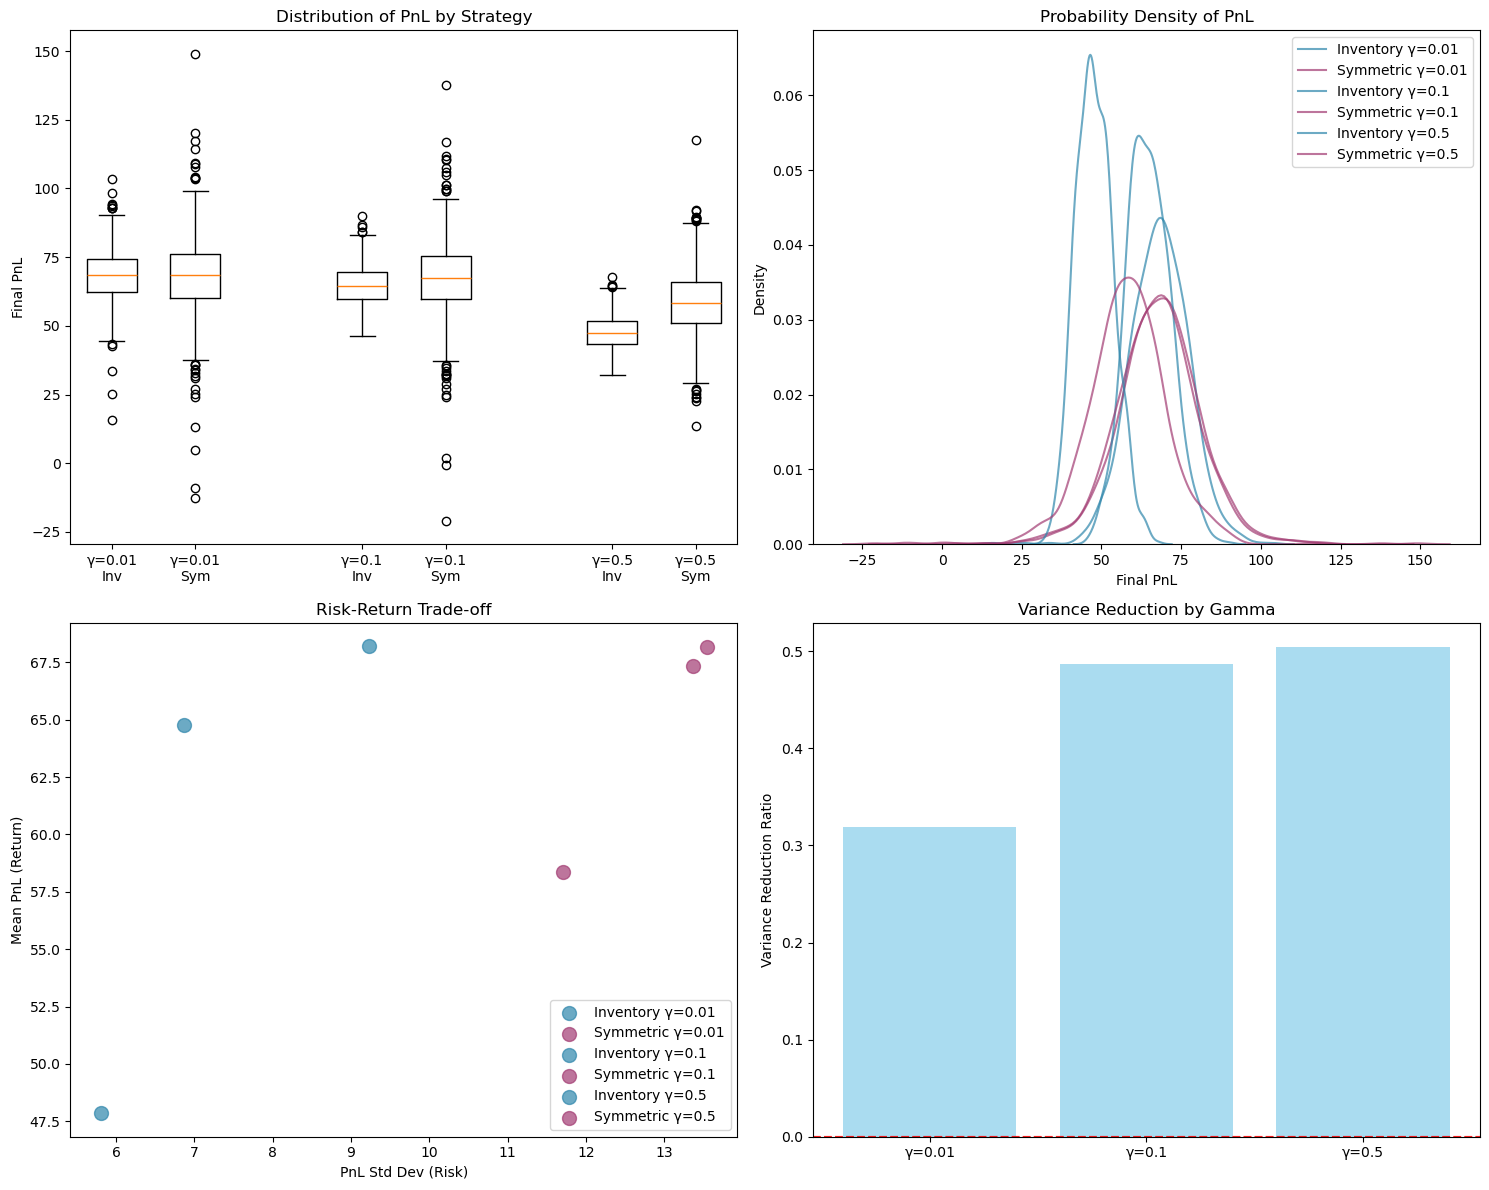

In [35]:
plot_strategy_comparison(all_results_gen, BASE_CONFIG)

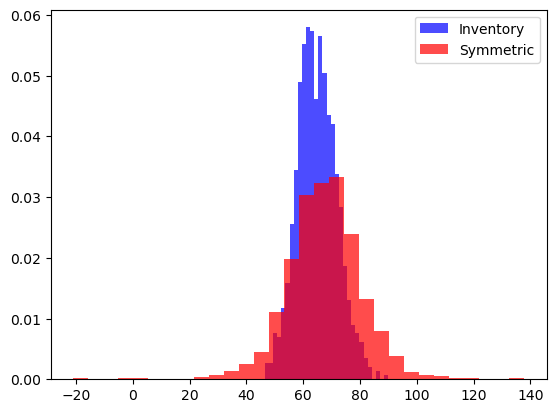

In [63]:
results = all_results_gen[0.1]
plt.plot(figsize=(18, 10))
plt.hist(results['inventory']['pnl_values'], bins=30, alpha=0.7, color='blue', label='Inventory', density=True)
plt.hist(results['symmetric']['pnl_values'], bins=30, alpha=0.7, color='red', label='Symmetric', density=True)
plt.legend()
plt.show()